<h2 style="text-align:center;"> HELLENIC OPEN UNIVERSITY - SCHOOL OF SCIENCE AND TECHNOLOGY</h2>
<h2 style="text-align:center;"> DATA SCIENCE AND MACHINE LEARNING : DAMA61 ACAD. YEAR 2024-25</h2>

<h3 style="text-align:center;"> WRITTEN ASSIGNMENT 3</h3>

<hr>

### Problem 1:

This problem concentrates on training models for the MNIST dataset using Decision Trees, Ensemble Models and Dimensionality reduction: <i>Please fix the random state to 42 where required.</i>

1) Open a Jupyter-notebook load the the MNIST dataset and split it to 80% training and 20% test parts using stratisfied splitting with a fixed random state (42). Retain only the 10000 first entries of the resulting training set and the first 2000 from the test set. Convert labels from array of strings to array of 64-bit integers. <b>[5%]</b>
2) Perform a Grid Search with 5-fold cross validation, with the maximum number of features taking the values [100, 150, 200], and the maximum depth the values [2, 4, 5], for a Decision Tree Classifier, using the Entropy criterion and fixed random state. Print the accuracy score, the F1 - score (set the average parameter set to "macro"), with respect to test data, and the values of the best parameters for the best estimator. Print the scores for all combinations and discuss the results. <b>[15%]</b>
3) Create a pipeline performing PCA, with fixed random state, retaining 90% of the variance of the initial features included in the training dataset, and train a Decision Tree with the depth parameter discovered in the previous question. Compute the accuracy and the F1 - score with respect to the test data and compare them with the previous results. Please discuss the advantages or disadvantages of using PCA. <b>[20%]</b>
4) Perform PCA with the number of components dictated in the previous question, compress the training data and train a Gradient Boosting Classifier (GBC). The model should have a maximum depth of 2, 6 estimators and learning rate equal to 1.0. The random state should be fixed where required. Discuss the results with respect to previously used Tree Classifier. How is it possible for GBC with shallow trees to outperform a deeper Tree Classifier? <b>[15%]</b>
5) Reconstruct the first five images (digits) by using the output of the PCA, of the previous question, and plot them along with their corresponding originals in the same figure and discuss. <b>[15%]</b>
6) Perform KMeans Clustering, with 20 clusters, using the PCA transformed training data and plot the most representative digits in a Figure with 2 rows and 10 columns. The most representative digit of each cluster is its corresponding centroid. <b>[15%]</b>
7) An important part of unsupervised learning is labelling. Manually label the printed images (centroirs) of the 20 clusters in Question #6 and store them in a vector. Then, label each sample of the test data based on the label of its nearest cluster (label propagation). By treating these assignments as predictions, compute the accuracy and F1 - score, with respect to test set labels, and compare to the previous approaches with respect also to the execution times of the trainig process. <b>[15%]</b>

### Helpful imports

In [1]:
# import the needed packages
import numpy as np
import pandas as pd
from collections import Counter

# increase the width of the notebook
from IPython.display import display, HTML, Markdown
display(HTML("<style>.container { width:90% !important; }</style>"))

# set the output of sklearn pipelines 
from sklearn import set_config
set_config(display="diagram")

# set the plotting parameters
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})

### Question 1

In [2]:
# load the MNIST dataset and check the keys of the mnist object
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False, parser='auto')

In [3]:
# split the data into features and target values
X, y = mnist["data"], mnist["target"]
y = y.astype(np.int64)

In [4]:
# Verify that both X and y are numpy arrays
assert (type(X) == np.ndarray) & (type(y) == np.ndarray)

In [5]:
from sklearn.model_selection import train_test_split

# apply stratified train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.20, 
                                                    stratify = y,
                                                    random_state = 42)

X_train = X_train[:10000]
y_train = y_train[:10000]

X_test = X_test[:2000]
y_test = y_test[:2000]

### Question 2

In [6]:
# import necessary method
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import GridSearchCV

# Train the model
tree_clf = DecisionTreeClassifier(criterion='entropy', random_state=42)

# Parameters for Grid Search
params = {'max_depth': [2, 4, 5], 'max_features' : [100, 150, 200]}

# Perform Grid Search and train the model
tree_clf2 = GridSearchCV(estimator = tree_clf, param_grid = params)
tree_clf2.fit(X_train, y_train)

# Predict 
y_pred = tree_clf2.best_estimator_.predict(X_test)

best_params = tree_clf2.best_estimator_.get_params()

print("Decision Tree Classifier:")
print(f"Best Max Depth: {best_params['max_depth']}")
print(f"Best Max Features: {best_params['max_features']}")
print(f"Accuracy score: {accuracy_score(y_test,y_pred):.2f}")
print(f"F1: {f1_score(y_test,y_pred, average= 'macro'):.2f}")
print()

for i_conf, conf in enumerate(tree_clf2.cv_results_['params']):
    print(f"Configuration: {conf}  Mean Test Score: {tree_clf2.cv_results_['mean_test_score'][i_conf]:.2f}")

Decision Tree Classifier:
Best Max Depth: 5
Best Max Features: 150
Accuracy score: 0.68
F1: 0.66

Configuration: {'max_depth': 2, 'max_features': 100}  Mean Test Score: 0.32
Configuration: {'max_depth': 2, 'max_features': 150}  Mean Test Score: 0.32
Configuration: {'max_depth': 2, 'max_features': 200}  Mean Test Score: 0.32
Configuration: {'max_depth': 4, 'max_features': 100}  Mean Test Score: 0.56
Configuration: {'max_depth': 4, 'max_features': 150}  Mean Test Score: 0.58
Configuration: {'max_depth': 4, 'max_features': 200}  Mean Test Score: 0.58
Configuration: {'max_depth': 5, 'max_features': 100}  Mean Test Score: 0.65
Configuration: {'max_depth': 5, 'max_features': 150}  Mean Test Score: 0.66
Configuration: {'max_depth': 5, 'max_features': 200}  Mean Test Score: 0.65


We can observe that increasing the depth has a significant impact on accuracy while an increase in features does not lead to significant increase in accuracy. This is an indication that there are reduntant features in the dataset.

### Question 3

In [7]:
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA

# Create pipeline
clf = make_pipeline(PCA(random_state = 42, n_components = 0.9),
                    DecisionTreeClassifier(criterion= 'entropy',
                                           max_depth = best_params['max_depth']))

# Fit model
clf.fit(X_train, y_train)

# Predict
y_pred = clf.predict(X_test)

print("PCA + Decision Tree Classifier:")
print(f"PCA dimensions: {clf[0].n_components_}")
print(f"Accuracy score: {accuracy_score(y_test, y_pred):.2f}")
print(f"F1: {f1_score(y_test, y_pred, average= 'macro'):.2f}")

PCA + Decision Tree Classifier:
PCA dimensions: 86
Accuracy score: 0.67
F1: 0.65


The result returned by PCA agrees with the result given by the previously performed Grid Search. The reduced number of features enables faster training for fixed models or use of more complicated models for fixed resources.

### Question 4

In [8]:
from sklearn.ensemble import GradientBoostingClassifier

# Define PCA
pca = PCA(random_state = 42, n_components = clf[0].n_components_)

# Define GBC model
gbrt_clf = GradientBoostingClassifier(max_depth = 2,
                                      n_estimators = 6,
                                      learning_rate = 1.0,
                                      random_state = 42)

# Transform input data
X_train_transformed = pca.fit_transform(X_train)

# Fit model
gbrt_clf.fit(X_train_transformed, y_train)

# Predict
y_pred = gbrt_clf.predict(pca.transform(X_test))

print("PCA + Gradient Boosting Classifier:")
print(f"Accuracy score: {accuracy_score(y_test,y_pred):.2f}")
print(f"F1: {f1_score(y_test,y_pred, average= 'macro'):.2f}")

PCA + Gradient Boosting Classifier:
Accuracy score: 0.77
F1: 0.77


Despite the weak classifiers used by the ensemble method the results are substantially improved. This is caused by the fact that Gradient Boosting Classifier trains each Tree classifier on the residual errors of the previous one. Thus, correcting the errors and improving the error metrics.

### Question 5

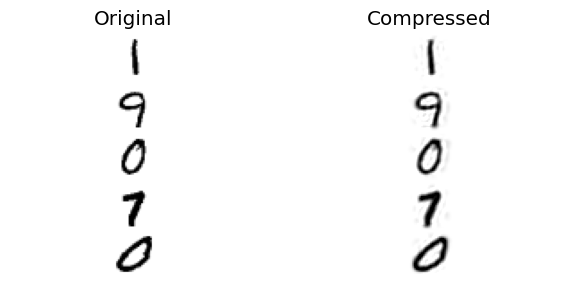

In [9]:
import matplotlib.pyplot as plt

# Inverse transform
X_inv = pca.inverse_transform(X_train_transformed)

N = 5
fig = plt.figure(figsize=(7, 4))
for idx, X in enumerate((X_train[0:N,:], X_inv[0:N,:])):
    plt.subplot(1, 2, idx + 1)
    plt.title(["Original", "Compressed"][idx])
    for row in range(N):
        plt.imshow(X[row,:].reshape(28, 28), cmap="binary",
                   vmin=0, vmax=255, extent=(2, 3, row, row + 1))
        plt.axis([0, 5, 0, 5])
        plt.axis("off")

The compression process, retaining reduced amount of features, did not significantly affect the images. This is because there is a large number of redundant dimensions in the dataset corresponding e.g. to empty pixels.

### Question 6

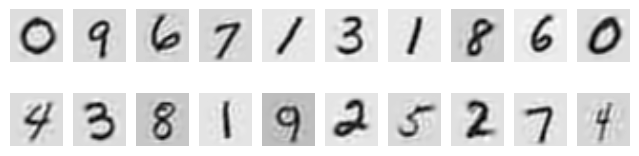

In [10]:
from sklearn.cluster import KMeans

# Set cluster number
k = 20

# Fit kmeans to the PCA data
kmeans = KMeans(n_clusters = 20, random_state = 42)

X_train_transformed_dist = kmeans.fit_transform(X_train_transformed)

# Find the images closer to the centroid
representative_digit_idx = np.argmin(X_train_transformed_dist, axis = 0)
X_representative_digits = X_train_transformed[representative_digit_idx]

# Print the most representative digits from each cluster
plt.figure(figsize=(8, 2))
for index, X_representative_digit in enumerate(X_representative_digits):
    plt.subplot(k // 10, 10, index + 1)
    plt.imshow(pca.inverse_transform(X_representative_digit).reshape(28, 28),
               cmap="binary",
               interpolation="bilinear")
    plt.axis('off')


### Question 7

In [11]:
# Manually label each class corresponding to each image
representative_labels = [0,9,6,7,1,3,1,8,6,0,
                         4,3,8,1,9,2,5,2,7,4]

# Predict the classes with respect to the test set
y_tmp = kmeans.predict(pca.transform(X_test))

# Label propagation
y_pred = np.empty(len(X_test), dtype = np.int64)
for i in range(k):
    y_pred[y_tmp == i] = representative_labels[i]

print("kMeans Classifier:")
print(f"Accuracy score*: {accuracy_score(y_test,y_pred):.2f}")
print(f"F1: {f1_score(y_test,y_pred, average= 'macro'):.2f}")

kMeans Classifier:
Accuracy score*: 0.70
F1: 0.69


The kMeans based predictions result in improved accuracy compared to the Tree Classifier and the PCA based variant, while simultaneously require less computational effort to train. The GBC method results in the best accuracy for this dataset but with substantial increase in computational work.

<hr>

### Problem 2
This problem focuses on supervised learning concepts using Ensemble Models, utilizing popular learning frameworks. Additionally, the final question benchmarks the performance of a semi-supervised learning approach using the scikit-learn library. Please fix the random state to 42 where required.

1) Load the provided dataset, **pima.csv**, print its shape and display the distribution of the target variable. A description of the dataset can be found in this link:
https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database/data. <b>[5%]</b>

2) Display the main statistical characteristics of each column in the data in a tabular format. Identify columns where the minimum value takes an unreasonable value equal to zero. Replace these zero values with the median of the corresponding column, as they represent missing values based on the dataset’s creation protocol. Print the updated dataset’s characteristics in a tabular format and list the columns affected by this step. <b>[15%]</b>

3) Perform a stratified split of the dataset, allocating 700 instances to the training set and the remaining samples to the test set. Ensure that the target variable is the **Outcome** column, while the rest of the columns constitute the feature space for the classification task. <b>[15%]</b>

4) Train the following models:
- A simple Decision Tree classifier using the default values of its parameters.
- A Random Forest classifier using the default values of its parameters.
- A Bagging classifier with an SVM classifier (linear kernel) and 10 estimators.
- An AdaBoost classifier with a decision tree classifier, using 100 estimators and a learning rate of 0.25.</br>
For each model, display a classification report presenting the standard classification metrics, precision, recall, and F1-score and the confusion matrix as they were calculated on the test set. <b>[20%]</b>

5) Compare the performance of the previous four models. Comment on the observed performance differences. <b>[20%]</b>

6) Select the best-performing classifier from Question #4 as the base model. Wrap it in an instance of the *SelfTrainingClassifier* class with the arguments *criterion='threshold'* and *threshold=0.99*. Randomly select 200 instances from the initial training set as labeled data, marking the rest as unlabeled. Train the semi-supervised model on the combined labeled and unlabeled data and train the supervised model on only the labeled data. Evaluate both models on the same test set, display the classification reports, and add your comments. <b>[10%]</b>

In [12]:
#Load packages
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

# increase the width of the notebook
from IPython.display import display, HTML, Markdown
display(HTML("<style>.container { width:90% !important; }</style>"))

# set the output of sklearn pipelines 
from sklearn import set_config
set_config(display="diagram")

import matplotlib.pyplot as plt
# set the plotting parameters
plt.rcParams.update({'font.size': 12})
%matplotlib inline

from sklearn.metrics import confusion_matrix

# set the random state
RANDOM_STATE = 42

### Question 1

In [13]:
# load the pima.csv datset from your local path
data = pd.read_csv('pima.csv')

# get the distribution of the target variable
data['Outcome'].value_counts()

Outcome
0    500
1    268
Name: count, dtype: int64

### Question 2

In [14]:
# use the .describe method to get the summary statistics of the data based on pandas library
data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [15]:
# detect columns that have zero values
zero_columns = [col for col in data.columns if (data[col].min() == 0 and col not in ["Pregnancies", "Outcome"])]
            
# replace zero values with NaN in targeted columns            
for col in zero_columns:
    data[col] = np.where(data[col]==0, np.nan, data[col])

In [16]:
# print the columns that have zero values
print("Columns that were affected by our pre-processing approach: \n")
for counter, col in enumerate(zero_columns):
    print(f"{counter+1}. {col}")

Columns that were affected by our pre-processing approach: 

1. Glucose
2. BloodPressure
3. SkinThickness
4. Insulin
5. BMI


In [17]:
# number of instances affected per existing column
print(data.isnull().sum())

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64


In [18]:
from sklearn.impute import SimpleImputer

# Create an imputer object with a median filling strategy
imputer = SimpleImputer(missing_values = np.nan,
                        strategy = "median")

for col in zero_columns:
    data.loc[:, col] = imputer.fit_transform(data.loc[:, col].values.reshape(-1, 1))

In [19]:
data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,121.656250,72.386719,29.108073,140.671875,32.455208,0.471876,33.240885,0.348958
std,3.369578,30.438286,12.096642,8.791221,86.383060,6.875177,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.750000,64.000000,25.000000,121.500000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,29.000000,125.000000,32.300000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


### Comment:

We observe that the columns **DiabetesPedigreeFunction**, **Age**, **Pregnancies**, and **Outcome** were not affected from our preprocessing stage.

### Question 3

In [20]:
X = data.drop('Outcome', axis=1)
y = data['Outcome']

# Define the number of instances for training and testing
train_size = 700  # Number of instances for training
test_size = 68    # Number of instances for testing

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size = train_size,
                                                    test_size = test_size,
                                                    stratify = y,
                                                    random_state = RANDOM_STATE)

### Question 4

In [21]:
# Good practice: scale the data before applying an SVM model
svc_pipeline = Pipeline([('scaler', MinMaxScaler()),
                         ('svm', SVC(random_state = RANDOM_STATE, kernel="linear"))])

estimators = [
    ('Decision Tree', DecisionTreeClassifier(random_state = RANDOM_STATE)),
    ('Random Forest', RandomForestClassifier(random_state = RANDOM_STATE)),
    ('Bagging SVC', BaggingClassifier(estimator = svc_pipeline, n_estimators = 10, random_state = RANDOM_STATE)),
    ('AdaBoost', AdaBoostClassifier(estimator = DecisionTreeClassifier(random_state = RANDOM_STATE),
                               n_estimators = 100, learning_rate = 0.25, random_state = RANDOM_STATE))
]

target_names = ['No', 'Yes']

models = {}
# train each estimator
for est in estimators:
    name, clf = est
    print(f"Training: {name}")
    clf.fit(X_train, y_train)
    
    y_pred = clf.predict(X_test)
    print(classification_report(y_test, y_pred, target_names=target_names))
    print("Confusion matrix:")
    print(confusion_matrix(y_test, y_pred))
    print()
    
    models[name] = clf  # store the trained model

Training: Decision Tree
              precision    recall  f1-score   support

          No       0.76      0.84      0.80        44
         Yes       0.63      0.50      0.56        24

    accuracy                           0.72        68
   macro avg       0.69      0.67      0.68        68
weighted avg       0.71      0.72      0.71        68

Confusion matrix:
[[37  7]
 [12 12]]

Training: Random Forest
              precision    recall  f1-score   support

          No       0.86      0.84      0.85        44
         Yes       0.72      0.75      0.73        24

    accuracy                           0.81        68
   macro avg       0.79      0.80      0.79        68
weighted avg       0.81      0.81      0.81        68

Confusion matrix:
[[37  7]
 [ 6 18]]

Training: Bagging SVC
              precision    recall  f1-score   support

          No       0.80      0.82      0.81        44
         Yes       0.65      0.62      0.64        24

    accuracy                        

### Question 5

Some typical comments, prioritizing the behavior of each model mainly over the positive instances:

1. The decision tree has moderate accuracy but struggles with recall, indicating it misses a significant number of positive cases.
2. Random Forest improves both recall and precision compared to a single decision tree, leading to a higher F1-score. It is more robust in handling positive cases.
3. Bagging of SVMs has balanced precision and recall. It is better than a single decision tree in terms of handling positives.
4. AdaBoost of decision trees has similar accuracy to a single decision tree but slightly lower recall. It struggles to handle positive cases effectively.

To sum up:
- **Best Classifier**: Random forest, has the highest F1-score and is the most balanced model.
- **Worst Classifier**: AdaBoost, has extremely poor recall and low overall performance.

### Question 6

In [22]:
# Create copies of the training sets
X_train_cp, y_train_cp = X_train.copy(), y_train.copy()

# Set the size of the boolean array
size = len(y_train_cp)

# Set the number of True values
num_true = 200

# Create an array with the specified number of True and False values
boolean_array = np.array([True] * num_true + [False] * (size - num_true))

# Shuffle the array to randomize the True/False values
np.random.seed(RANDOM_STATE)
np.random.shuffle(boolean_array)

assert num_true == np.count_nonzero(boolean_array)

In [23]:
# annotate as -1 the randomly chosen unlabeled instances 
y_train_cp[boolean_array] = -1
y_train_cp.value_counts()

Outcome
 0    316
-1    200
 1    184
Name: count, dtype: int64

In [28]:
# train and predict using the self-training wrapper with the best ensemble model from the previous question
self_training_model = SelfTrainingClassifier(models["Random Forest"],
                                             criterion = "threshold",
                                             threshold = 0.99)

self_training_model.fit(X_train_cp, y_train_cp)
y_pred = self_training_model.predict(X_test)

print(classification_report(y_test, y_pred, target_names = target_names))
print()
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

          No       0.86      0.84      0.85        44
         Yes       0.72      0.75      0.73        24

    accuracy                           0.81        68
   macro avg       0.79      0.80      0.79        68
weighted avg       0.81      0.81      0.81        68


[[37  7]
 [ 6 18]]


In [25]:
# check the distribution of the training instances after the self-training process 
np.array(np.unique(self_training_model.transduction_, return_counts=True)).T

array([[ -1, 185],
       [  0, 331],
       [  1, 184]])

In [26]:
# isolate the initially labeled instances
X_train_supervised_model = X_train[y_train_cp != -1]
y_train_supervised_model = y_train[y_train_cp != -1]

X_train_supervised_model.shape, y_train_supervised_model.shape

((500, 8), (500,))

In [27]:
# train the same ensemble model with the labeled instances
models["Random Forest"].fit(X_train_supervised_model, y_train_supervised_model)
y_pred = models["Random Forest"].predict(X_test)

print(classification_report(y_test, y_pred, target_names = target_names))
print()
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

          No       0.84      0.82      0.83        44
         Yes       0.68      0.71      0.69        24

    accuracy                           0.78        68
   macro avg       0.76      0.76      0.76        68
weighted avg       0.78      0.78      0.78        68


[[36  8]
 [ 7 17]]


**Comment**: The self-training process performs well across the measured metrics.

However, the model exhibited a strong preference for the negative class, as almost all the unlabeled instances added to the original 200 labeled examples belonged to the negative class.

Furthermore, the performance of the semi-supervised variant is highly sensitive to the choice of the threshold and k_best parameters. The presence of unlabeled examples alone does not guarantee performance improvement. This can be observed by varying these parameter values and noting the impact on performance.